# Diagnosis of COVID-19 and its clinical spectrum (MODELING)

# Project Overview

  >The World Health Organization (WHO) characterized the COVID-19, caused by the SARS-CoV-2, as a pandemic on March 11, while the exponential increase in the number of cases was risking to overwhelm health systems around the world with a demand for ICU beds far above the existing capacity, with regions of Italy being prominent examples.

  >Brazil recorded the first case of SARS-CoV-2 on February 26, and the virus transmission evolved from imported cases only, to local and finally community transmission very rapidly, with the federal government declaring nationwide community transmission on March 20.

  >Until March 27, the state of São Paulo had recorded 1,223 confirmed cases of COVID-19, with 68 related deaths, while the county of São Paulo, with a population of approximately 12 million people and where Hospital Israelita Albert Einstein is located, had 477 confirmed cases and 30 associated death, as of March 23. Both the state and the county of São Paulo decided to establish quarantine and social distancing measures, that will be enforced at least until early April, in an effort to slow the virus spread.

  >One of the motivations for this challenge is the fact that in the context of an overwhelmed health system with the possible limitation to perform tests for the detection of SARS-CoV-2, testing every case would be impractical and tests results could be delayed even if only a target subpopulation would be tested.

## Objective

> Predict confirmed COVID-19 cases among suspected cases.
Based on the results of laboratory tests commonly collected for a suspected COVID-19 case during a visit to the emergency room, would it be possible to predict the test result for SARS-Cov-2 (positive/negative)?

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore")

RANDOM_STATE=42

In [3]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

file_path = "dataset.xlsx"

data = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "einsteindata4u/covid19",
  file_path,
)

df = data.copy()

100%|██████████| 568k/568k [00:00<00:00, 1.68MB/s]


# **DATA PREPROCESSING**

In [4]:
missing_rate = df.isna().sum()/df.shape[0]

blood_columns = list(df.columns[(missing_rate > 0.88) & (missing_rate < 0.9)])
viral_columns = list(df.columns[(missing_rate > 0.75) & (missing_rate < 0.80)])

key_columns = ['Patient age quantile', 'SARS-Cov-2 exam result']

df = df[key_columns + blood_columns + viral_columns]

## Train/Test

In [5]:
from sklearn.model_selection import train_test_split
trainset, testset = train_test_split(df, test_size=0.2, random_state=RANDOM_STATE)

In [6]:
display(trainset['SARS-Cov-2 exam result'].value_counts(normalize=True))
display(testset['SARS-Cov-2 exam result'].value_counts(normalize=True))

,proportion
SARS-Cov-2 exam result,
negative,0.900332
positive,0.099668


,proportion
SARS-Cov-2 exam result,
negative,0.90434
positive,0.09566


## Data modeling

In [7]:
def encoding(df):
  code = {
    'positive' : 1,
    'negative' : 0,
    'detected' : 1,
    'not_detected' : 0
    }

  for col in df.select_dtypes('object'):
    df[col] = df[col].map(code)

  return df

In [8]:
def imputation(df):
  # df = df.fillna(0)
  df = df.dropna(axis=0)
  return df

In [9]:
def feature_engineering(df):
  df['sick'] = df[viral_columns].sum(axis=1)
  df = df.drop(columns=viral_columns)
  return df

In [10]:
def preprocessing(df):
  """perform preprocessing"""
  df = encoding(df)
  df = imputation(df)
  df = feature_engineering(df)

  X = df.drop("SARS-Cov-2 exam result", axis=1)
  y = df['SARS-Cov-2 exam result']

  return X, y

In [11]:
def evaluation(model, X_train, y_train, X_test, y_test):
    # Train
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Metrics
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:\n", cm)

    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)

    f1 = f1_score(y_test, y_pred, average='weighted')
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average='weighted')
    recall = recall_score(y_test, y_pred, average='weighted')

    # Learning curve
    N, train_score, val_score = learning_curve(
        model,
        X_train,
        y_train,
        cv=5,
        scoring='f1',
        train_sizes=np.linspace(0.1, 1, 10)
    )

    fig, ax = plt.subplots(figsize=(12, 8))
    ax.plot(N, train_score.mean(axis=1), label='train score')
    ax.plot(N, val_score.mean(axis=1), label='validation score')
    ax.set_xlabel('Training size')
    ax.set_ylabel('F1 score')
    ax.legend()

    return {
        'f1_score': f1,
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'learning_curve_figure': fig
    }

## Modeling

**Analysis**:
- Train base model for RandomForest, AdaBoost, GradientBoosting, and SVM

**Key Obsevation**:
- SVM seems to be most effective model with 0.70 recall/ 0.82 F1 score on positive class.
- SVM learning curve seems to generalize better on validation set.

**Action Taken**: SVM fine tuning.

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, make_scorer
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV, learning_curve

In [13]:
dict_of_models = {}

preprocessor = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)),
    ('kbest', SelectKBest(score_func=f_classif, k=20))
])

random_forest = Pipeline(
    [('preprocessor', preprocessor),
     ('classifier', RandomForestClassifier(random_state=42))]
)
adaboost = Pipeline(
    [('preprocessor', preprocessor),
     ('classifier', AdaBoostClassifier(random_state=42))]
)
gradient_boosting = Pipeline(
    [('preprocessor', preprocessor),
     ('classifier', GradientBoostingClassifier(random_state=42))]
)
svm = Pipeline(
    [('preprocessor', preprocessor),
     ('standardScaler', StandardScaler()),
     ('classifier', SVC(random_state=42))]
)

dict_of_models['RandomForest'] = random_forest
dict_of_models['AdaBoost'] = adaboost
dict_of_models['GradientBoosting'] = gradient_boosting
dict_of_models['SVM'] = svm

In [14]:
X, y = preprocessing(trainset)

# Split trainset into train + validation
X_train, X_val, y_train, y_val = train_test_split(
    X, y,
    test_size=0.2,        # 20% of trainset as validation
    random_state=42,
    stratify=y            # preserves class distribution
)


Model: RandomForest
Confusion Matrix:
 [[48  3]
 [ 4  4]]
Classification Report:
               precision    recall  f1-score   support

           0       0.92      0.94      0.93        51
           1       0.57      0.50      0.53         8

    accuracy                           0.88        59
   macro avg       0.75      0.72      0.73        59
weighted avg       0.88      0.88      0.88        59

Model: AdaBoost
Confusion Matrix:
 [[47  4]
 [ 5  3]]
Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.92      0.91        51
           1       0.43      0.38      0.40         8

    accuracy                           0.85        59
   macro avg       0.67      0.65      0.66        59
weighted avg       0.84      0.85      0.84        59

Model: GradientBoosting
Confusion Matrix:
 [[47  4]
 [ 3  5]]
Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.92      0.93  

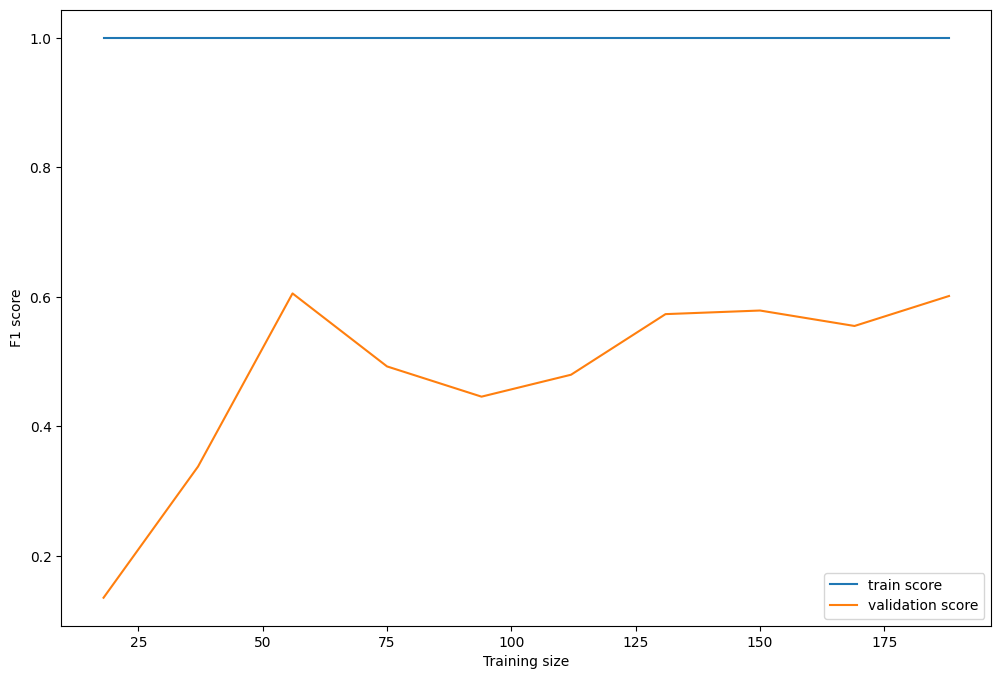

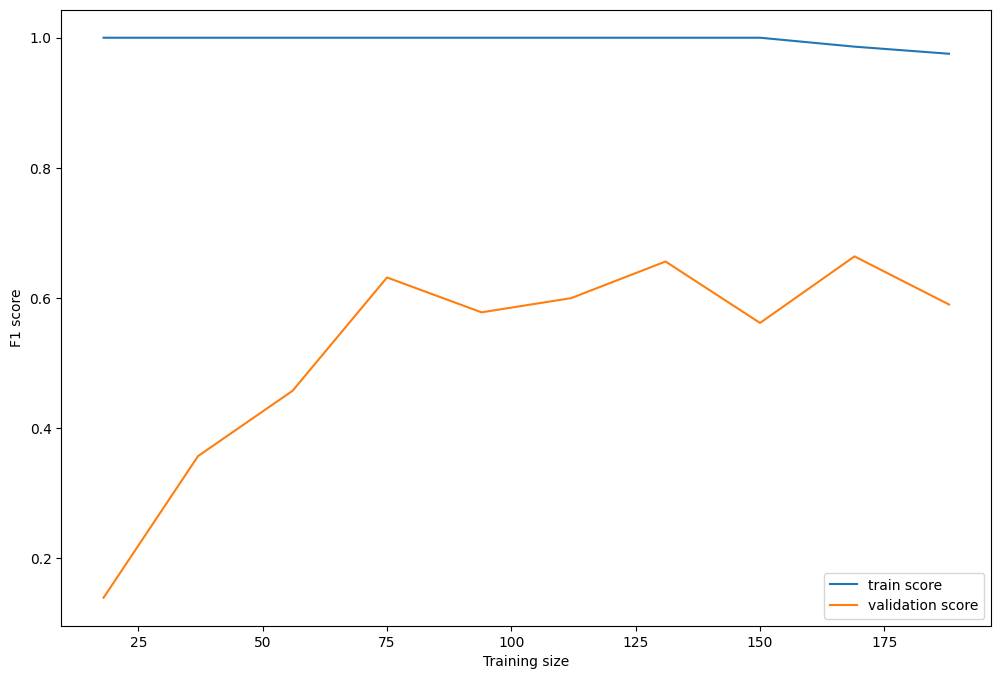

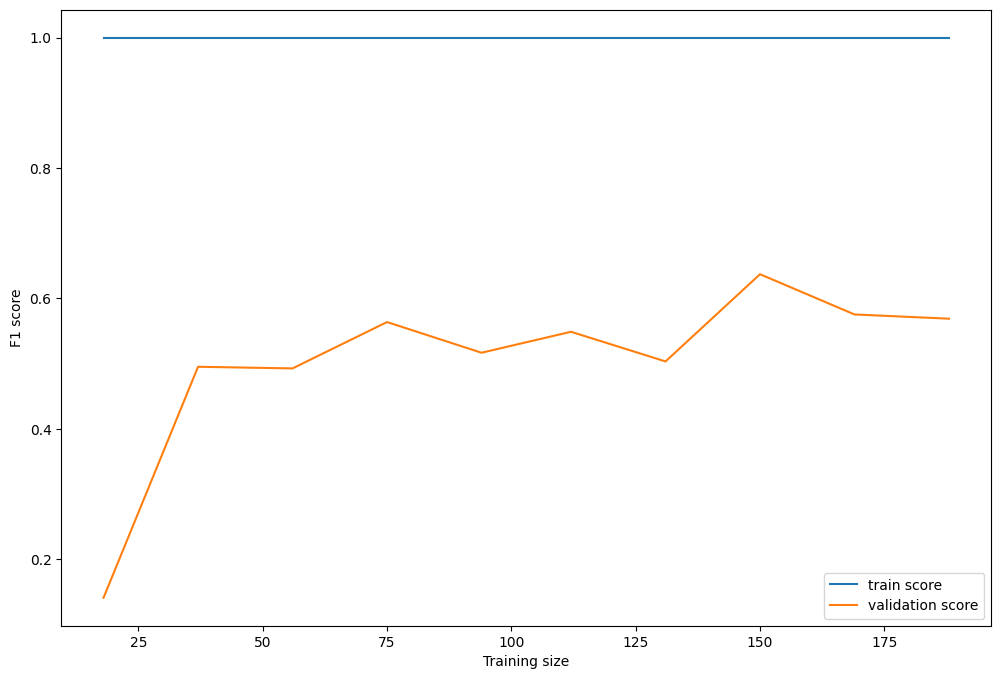

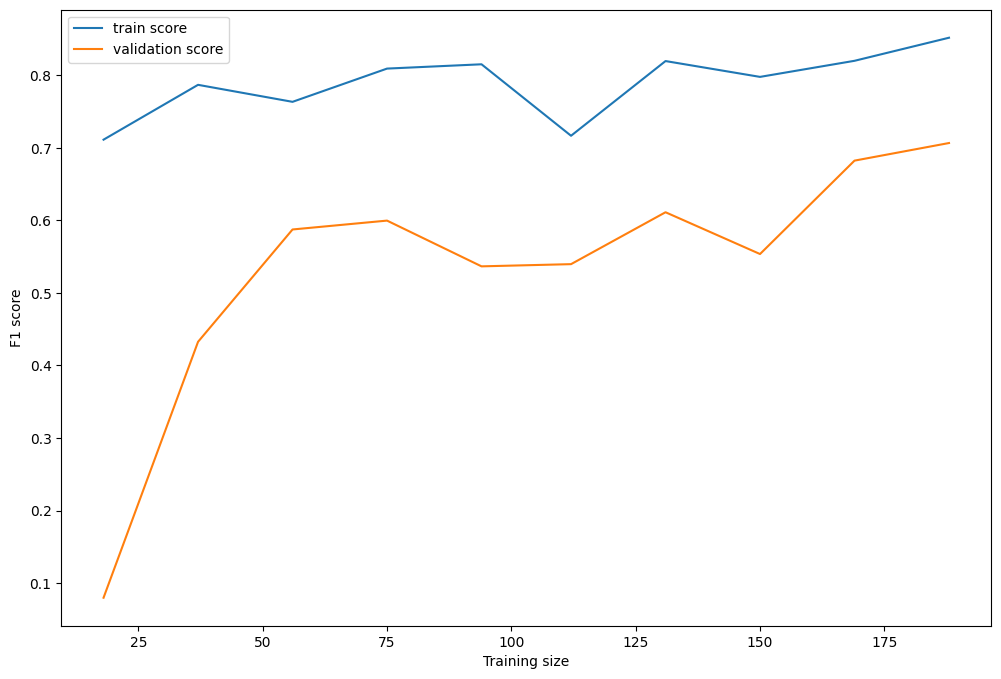

In [60]:
for model_name, model in dict_of_models.items():
  print(f"Model: {model_name}")
  results = evaluation(model, X_train, y_train, X_val, y_val)

## Feature Importance Analysis

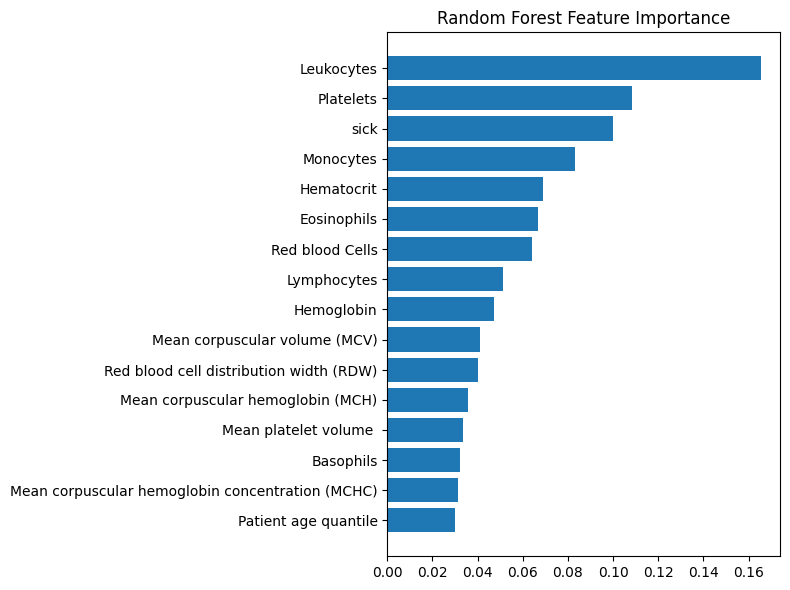

In [22]:
# Fit a baseline model
rf = RandomForestClassifier(n_estimators=300, random_state=42)
rf.fit(X_train, y_train)

rf_importance = rf.feature_importances_

importances = rf.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(8, 6))
plt.barh(range(len(importances)), importances[indices])
plt.yticks(range(len(importances)), X_train.columns[indices])
plt.title("Random Forest Feature Importance")
plt.tight_layout()
plt.show()

## SVM Fine-tuning

**Analysis**:
- SVM hyperparameter randomized search (Polynomial features, Kbest, gamma, kernel, C).

**Key observation**:
- Best estimator with {'preprocessor__poly__degree': 1,
 'preprocessor__kbest__k': 20,
 'classifier__kernel': 'rbf',
 'classifier__gamma': 'scale',
 'classifier__C': 1}
- F1 Score of 0.693.
- Increasing Learning curve

**Action Taken**: None

**Future Consideration**: Precision/Recall analysis and decision threshold.

In [15]:
!pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.0/40.0 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.9/8.9 MB 89.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 65.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 9.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.8/76.8 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 753.9/753.9 kB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 16.4 MB/s eta 0:00:00


In [16]:
from google.colab import drive
drive.mount('/content/drive')

from sklearn.metrics import f1_score, confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
from sklearn.model_selection import learning_curve
import mlflow
import mlflow.sklearn

mlflow.set_tracking_uri("/content/drive/MyDrive/mlruns")

Mounted at /content/drive


In [17]:
mlflow.set_experiment("COVID-19_modelling_v2")

<Experiment: artifact_location='/content/drive/MyDrive/mlruns/924225955544446265', creation_time=1763121946785, experiment_id='924225955544446265', last_update_time=1763121946785, lifecycle_stage='active', name='COVID-19_modelling_v2', tags={}>

In [52]:
svm

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('poly',
                                  PolynomialFeatures(include_bias=False)),
                                 ('kbest', SelectKBest(k=20))])),
                ('standardScaler', StandardScaler()),
                ('classifier', SVC(random_state=42))])

In [18]:
X_train, y_train = preprocessing(trainset)
X_test, y_test = preprocessing(testset)

param_dist = {
    # Polynomial degree
    'preprocessor__poly__degree': [1, 2, 3],
    # SelectKBest number of features
    'preprocessor__kbest__k': [10, 20, 30, 'all'],
    # SVC hyperparameters
    'classifier__C': [0.1, 1, 10, 50],
    'classifier__gamma': ['scale', 0.01, 0.001],
    'classifier__kernel': ['rbf', 'poly']
}



random_search = RandomizedSearchCV(
    svm,
    param_distributions=param_dist,
    n_iter=20,  # number of random combinations to try
    scoring=make_scorer(f1_score),
    cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
    n_jobs=-1,
    random_state=42,
    verbose=1
)

with mlflow.start_run(run_name="SVM_RandomSearch"):

    # Log hyperparameter search space
    # mlflow.log_params({k: str(v) for k, v in param_dist.items()})

    # Fit RandomizedSearchCV
    random_search.fit(X_train, y_train)

    # Log best parameters
    # mlflow.log_params({f"best_{k}": v for k, v in random_search.best_params_.items()})

    # Evaluate on validation set
    y_val_pred = random_search.predict(X_val)

    # Metrics
    f1 = f1_score(y_val, y_val_pred)
    # mlflow.log_metric("val_f1_weighted", f1)

    # Optional: log classification report
    report = classification_report(y_val, y_val_pred, output_dict=True)
    # for label, metrics in report.items():
    #     if isinstance(metrics, dict):
    #         for metric_name, value in metrics.items():
    #             mlflow.log_metric(f"{label}_{metric_name}", value)

    # Log model
    # mlflow.sklearn.log_model(random_search.best_estimator_, artifact_path="model")


Fitting 5 folds for each of 20 candidates, totalling 100 fits


In [19]:
display(random_search.best_score_)
display(random_search.best_params_)
best_model = random_search.best_estimator_

np.float64(0.693288084464555)

{'preprocessor__poly__degree': 3,
 'preprocessor__kbest__k': 30,
 'classifier__kernel': 'rbf',
 'classifier__gamma': 'scale',
 'classifier__C': 50}

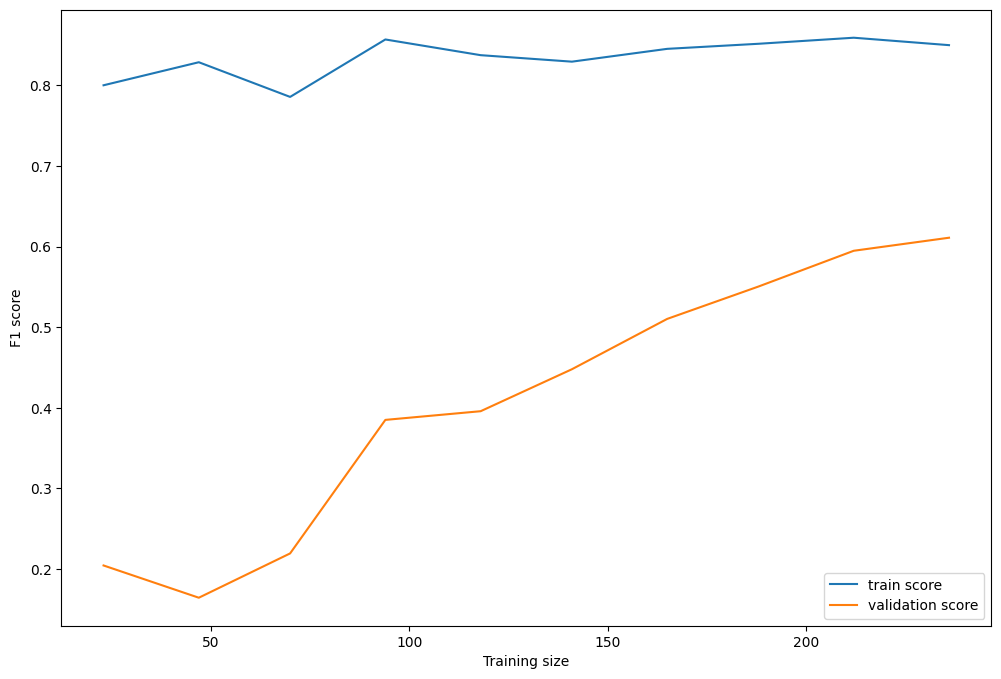

In [64]:
# plot learning curve
N, train_score, val_score = learning_curve(
    best_model,
    X_train,
    y_train,
    cv=5,
    scoring='f1',
    train_sizes=np.linspace(0.1, 1, 10)
)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(N, train_score.mean(axis=1), label='train score')
ax.plot(N, val_score.mean(axis=1), label='validation score')
ax.set_xlabel('Training size')
ax.set_ylabel('F1 score')
ax.legend()



## Precision/Recall Analysis

**Analysis**: Precision / Recall curve

**Key Obeservations**:
- Best F1 Score 0.61 at threshold 0
- We can increase favor recall score with a threhold of 1

**Action taken**:
- Set the decision threshold at -1 to increase recall

**Future Consideration**: None

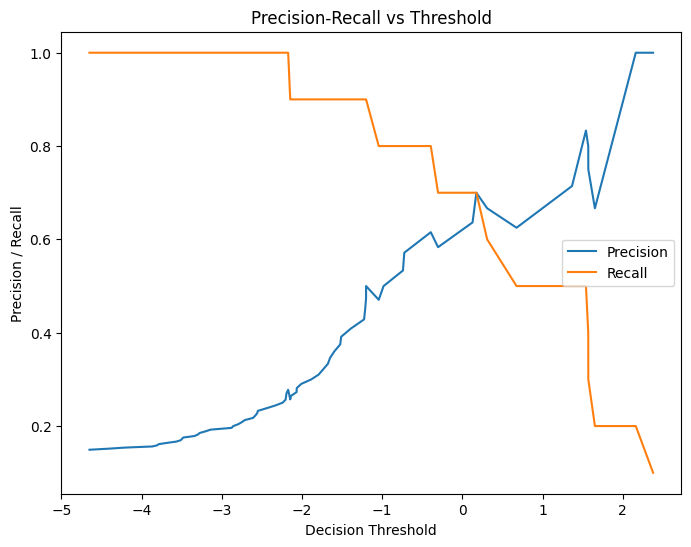

In [20]:
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

# decision scores instead of probabilities
y_scores = best_model.decision_function(X_test)

# Precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, y_scores)

# Plot precision and recall vs threshold
plt.figure(figsize=(8,6))
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Decision Threshold')
plt.ylabel('Precision / Recall')
plt.title(f'Precision-Recall vs Threshold')
plt.legend()
plt.show()


In [77]:
def final_model(model, X, threshold=1):
  return model.decision_function(X) > threshold

In [80]:
y_pred_f = final_model(best_model, X_test, threshold=-1)

In [81]:
f1_score(y_test, y_pred_f)

0.6153846153846154

# Conclusion

> Best explored model is fine-tuned SVM with F1 Score of 0.61 with a decision threshold of -1 to increase recall.